In [ ]:
!pwd

In [4]:
%cd ..

/workarea/otdMDP/users/amoskovtsev/Pycharm_proj/MB_OPC/custom_unet


In [88]:
import cv2
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_sched
from torchvision import transforms, datasets
from torchinfo import summary
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import logging
import time
import sys
import os

from src.utils import next_exp_folder, draw_plot
from src.dataset import OPCDataset, BinarizeTransform, calculate_mean_std, apply_transform
from src.config import DATASET_PATH, CHECKPOINT_PATH, BATCH_SIZE, EPOCHS, LEARNING_RATE

def set_random_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)

set_random_seed(42)

def setup_logging(exp_folder):
  # Set up logging configuration
  log_file_path = os.path.join(exp_folder, 'training_log.txt')
  logging.basicConfig(filename = log_file_path,
                      level = logging.INFO,
                      datefmt = '%d/%m/%Y %H:%M')


data_transforms = {
  'train': transforms.Compose([
    transforms.Resize(1024),
    transforms.ToTensor(),
    transforms.Grayscale(),
    BinarizeTransform(threshold=0.5)
  ]),
  'val': transforms.Compose([
    transforms.Resize(1024),
    transforms.ToTensor(),
    transforms.Grayscale(),
    BinarizeTransform(threshold=0.5)
  ])
}

BATCH_SIZE = 3
DATA_DIR = 'data/processed/classifier/'
TRAIN_DATASET = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), data_transforms['train'])
VAL_DATASET = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'), data_transforms['val'])
TEST_DATASET = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), data_transforms['val'])

TRAIN_LOADER = torch.utils.data.DataLoader(TRAIN_DATASET, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)
VAL_LOADER = torch.utils.data.DataLoader(VAL_DATASET, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)
TEST_LOADER = torch.utils.data.DataLoader(TEST_DATASET, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class_names = TRAIN_DATASET.classes
dataset_sizes = {'train': len(TRAIN_DATASET), 'val': len(VAL_DATASET)}
print(f'Dataset size:{dataset_sizes}')
print(f'Class names:{class_names}')



Dataset size:{'train': 28796, 'val': 3230}
Class names:['correction', 'origin']


In [76]:
images, labels = next(iter(TRAIN_LOADER))
print(images.shape)
print(labels.shape)

torch.Size([3, 1, 1024, 1024])
torch.Size([3])


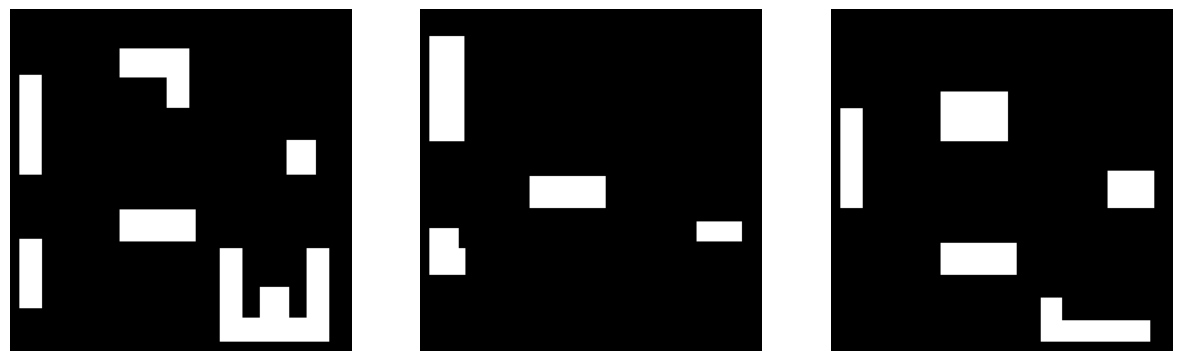

In [96]:
images, labels = next(iter(VAL_LOADER))
fig, axs = plt.subplots(1, BATCH_SIZE, figsize=(15, 5))

# Loop through the batch and plot each image
for i in range(BATCH_SIZE):
    axs[i].imshow(images[i].squeeze(0), cmap='gray')  # Display the image
    axs[i].axis('off')  # Turn off axis

plt.show()

Делаем `Average Pooling` над картинкой:

torch.Size([3, 1, 256, 256])


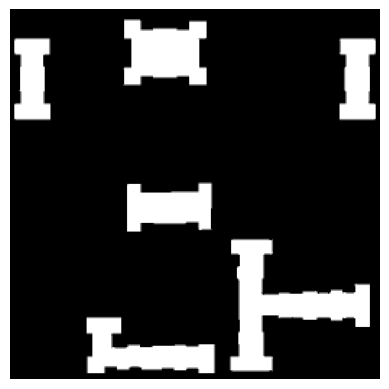

In [58]:
%matplotlib inline
avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
result = avg_pool(images)
print(result.shape)

plt.imshow(result[1].squeeze(0), cmap='gray')
plt.axis('off')
plt.show()

Делаем свёртку:

torch.Size([3, 1, 512, 512])


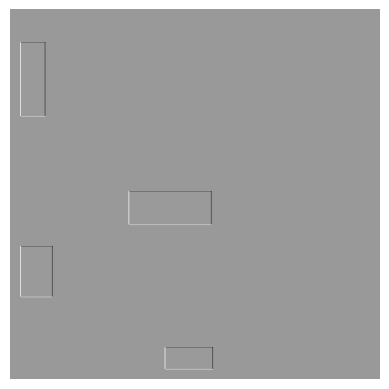

In [46]:
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=1)
conv_result = conv2d(images)

print(conv_result.shape)
plt.imshow(conv_result[1].detach().numpy().squeeze(0), cmap='gray')
plt.axis('off')
plt.show()